In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', 999)

In [3]:
A = 'Quality_data.csv'

quality_data = pd.read_csv(A)

In [4]:
new_quality = quality_data

for i in range(len(quality_data)-1, -1 , -1):
    if np.array(quality_data.iloc[i, 14:15]) == 'b' or (np.array(quality_data.iloc[i, 0:1])[0] > 0) == False:
        new_quality = new_quality.drop(new_quality.index[i])

In [5]:
nozero_quality = new_quality

for i in range(len(new_quality)-1, -1 , -1):
    if np.array(new_quality.iloc[i, 15:16]) == 0:
        nozero_quality = nozero_quality.drop(nozero_quality.index[i])

In [6]:
Y = np.matrix(nozero_quality.iloc[:, 15:16])

X = np.matrix(nozero_quality.iloc[:, 16:17])

In [7]:
Rework_0 = []
Rework_1 = []
Rework_2 = []

for i in range(len(X)):
    if X[i] == 0:
        Rework_0.append(np.array(np.array(Y[i])[0])[0])
    if X[i] == 1:
        Rework_1.append(np.array(np.array(Y[i])[0])[0])
    if X[i] == 2:
        Rework_2.append(np.array(np.array(Y[i])[0])[0])

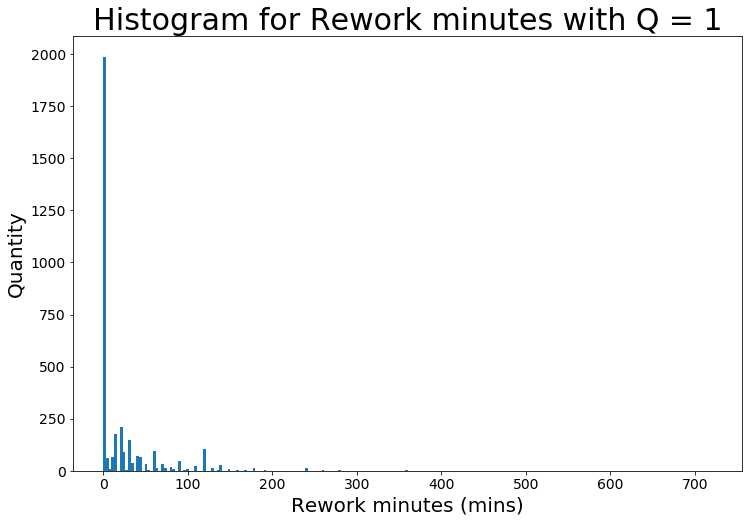

In [8]:
def formatting(ax):
    ax.set_xlabel('Rework minutes (mins)',fontsize = 20 )
    ax.set_ylabel('Quantity',fontsize = 20)
    ax.tick_params(labelsize=14)
    ax.set_title('Histogram for Rework minutes with Q = 1', fontsize = 30)
    return ax

fig = plt.figure(figsize = [12, 8])
ax = fig.add_subplot(111)
plt.hist(Rework_1, bins='auto')
ax = formatting(ax)
plt.show()

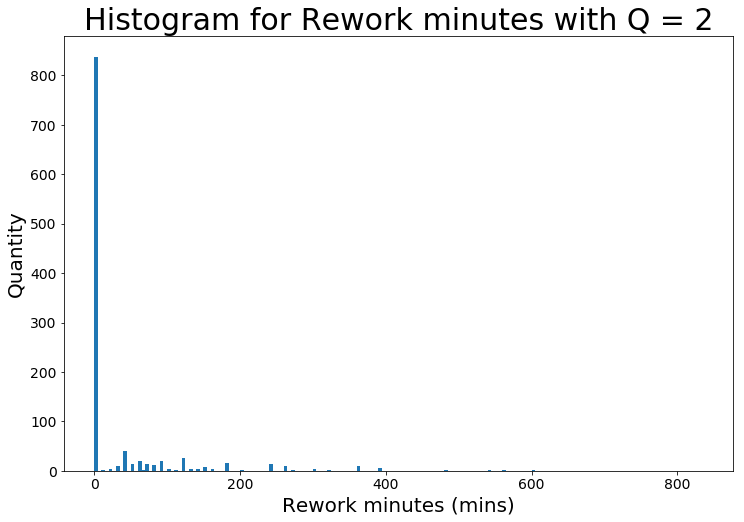

In [9]:
def formatting(ax):
    ax.set_xlabel('Rework minutes (mins)',fontsize = 20 )
    ax.set_ylabel('Quantity',fontsize = 20)
    ax.tick_params(labelsize=14)
    ax.set_title('Histogram for Rework minutes with Q = 2', fontsize = 30)
    return ax

fig = plt.figure(figsize = [12, 8])
ax = fig.add_subplot(111)
plt.hist(Rework_2, bins=np.arange(0, np.max(Rework_2), 5))
ax = formatting(ax)
plt.show()

In [10]:
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats

## Rework minutes for Q = 1

In [11]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

In [12]:
# Create an index array (x) for data

y_1 = np.array(Rework_1)

x_1 = np.arange(len(y_1))
size = len(y_1)

In [13]:
y_1_df = pd.DataFrame(Rework_1, columns=['Data'])
y_1_df.describe()

,Data
count,3448.000000
mean,22.618103
std,43.955098
min,0.020000
25%,0.200000
50%,0.500000
75%,25.000000
max,720.000000


In [14]:
sc = StandardScaler() 
yy_1 = y_1.reshape (-1,1)
sc.fit(yy_1)
y_1_std =sc.transform(yy_1)
y_1_std = y_1_std.flatten()
y_1_std
del yy_1

In [15]:
# Set up empty lists to store results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_1_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_1_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

for i in range(len(cum_observed_frequency)):
    if cum_observed_frequency[i] == 0:
        cum_observed_frequency[i] = cum_observed_frequency[i] + 1

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_1_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_1_std, distribution, args=param)[1]
    #p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square        p_value
5     pearson3   5984.467424  2.945895e-281
0         beta   9026.494810  5.712157e-165
8  weibull_min   9148.873809  6.901297e-121
3      lognorm  12749.003537   4.114296e-65
1        expon  21608.995926   0.000000e+00
2        gamma  23636.976735  1.310823e-117
4         norm  42148.542175  2.127121e-276
6       triang  64142.799895   0.000000e+00
7      uniform  68963.193355   0.000000e+00
9  weibull_max  77033.936942   0.000000e+00


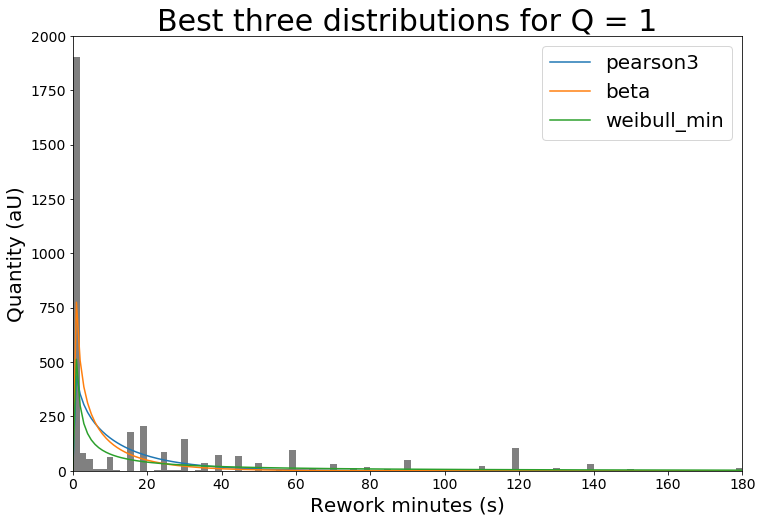


Distribution parameters:
------------------------
('\nDistribution:', 'pearson3')
('Parameters:', (2.2456568200828837, 12.442100724647183, 13.947887606030243))
('\nDistribution:', 'beta')
('Parameters:', (0.48818773361674217, 384.6733336301611, 0.019999999999999997, 5998.635513860994))
('\nDistribution:', 'weibull_min')
('Parameters:', (0.37597148395512975, 0.019999999999999997, 20.428066823966425))


In [16]:
plt.figure(figsize = [12,8])

plt.xlabel('Rework minutes (s)',fontsize = 20 )
plt.ylabel('Quantity (aU)',fontsize = 20)
plt.tick_params(labelsize=14)
plt.title('Best three distributions for Q = 1', fontsize = 30)


# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y_1,0), np.percentile(y_1,99),number_of_bins)

# Create the plot
h = plt.hist(y_1, bins = bin_cutoffs, color='0.5')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y_1)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x_1, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x_1)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0, np.percentile(y_1,99))

    
# Add legend and display plot

plt.legend(loc=1, prop={'size': 20})
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )


## Rework minutes for Q = 2

In [17]:
# Create an index array (x) for data

y_2 = np.array(Rework_2)

x_2 = np.arange(len(y_2))
size = len(y_2)

In [18]:
y_2_df = pd.DataFrame(Rework_2, columns=['Data'])
y_2_df.describe()

,Data
count,1086.000000
mean,30.832449
std,78.967721
min,0.040000
25%,0.400000
50%,0.400000
75%,2.000000
max,840.000000


In [19]:
sc = StandardScaler() 
yy_2 = y_2.reshape (-1,1)
sc.fit(yy_2)
y_2_std =sc.transform(yy_2)
y_2_std = y_2_std.flatten()
y_2_std
del yy_2

In [20]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']

In [21]:
# Set up empty lists to store results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_2_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_2_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

for i in range(len(cum_observed_frequency)):
    if cum_observed_frequency[i] == 0:
        cum_observed_frequency[i] = cum_observed_frequency[i] + 1

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_2_std)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_2_std, distribution, args=param)[1]
    #p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = sum(((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square        p_value
1        expon   4999.543212   0.000000e+00
9  weibull_max   6813.517816  1.858930e-213
4         norm   9154.643181  1.020244e-163
6       triang  11535.559259   0.000000e+00
7      uniform  13438.388268   0.000000e+00
2        gamma  18457.914258  2.552855e-253
0         beta  31117.062182  1.213613e-169
3      lognorm  46426.458787  3.327405e-127
5     pearson3  50393.904519  6.643098e-151
8  weibull_min  66583.395603  4.240180e-103


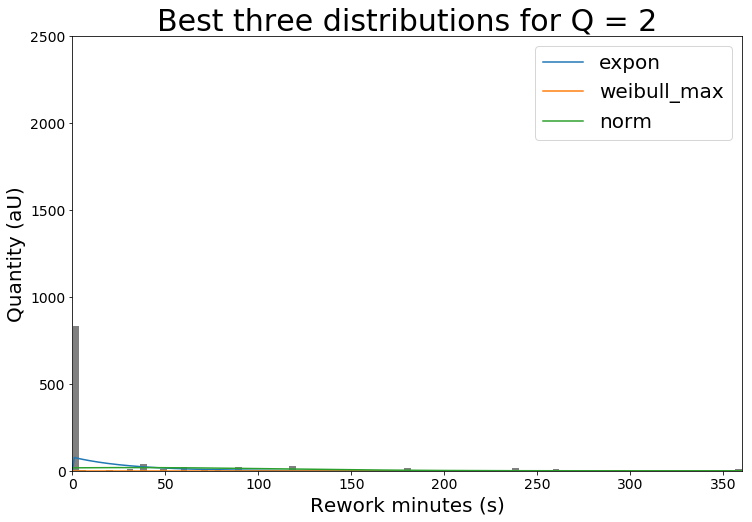


Distribution parameters:
------------------------
('\nDistribution:', 'expon')
('Parameters:', (0.04, 30.792449355432776))
('\nDistribution:', 'weibull_max')
('Parameters:', (0.13133717045425863, 840.0000000000002, 1.7933391648134251))
('\nDistribution:', 'norm')
('Parameters:', (30.832449355432775, 78.93135523661486))


In [22]:
plt.figure(figsize = [12,8])

plt.xlabel('Rework minutes (s)',fontsize = 20 )
plt.ylabel('Quantity (aU)',fontsize = 20)
plt.tick_params(labelsize=14)
plt.title('Best three distributions for Q = 2', fontsize = 30)


# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 100
bin_cutoffs = np.linspace(np.percentile(y_2,0), np.percentile(y_2,99), number_of_bins)

# Create the plot
h = plt.hist(y_2, bins = bin_cutoffs, color='0.5')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 3
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y_2)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x_2, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x_2)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0, np.percentile(y_2,99))
    #plt.ylim(0, 100)

# Add legend and display plot

plt.legend(loc=1, prop={'size': 20})
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )